## 卷積神經網路（CNN）

### CNN基本實作

使用與FFNN相同的資料集，看CNN可以提升多少準確度。

### 準備資料

先讀取資料、並進行資料處理

In [7]:
#1 準備資料
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold

# 讀取資料集
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_x = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# 提取x, y
train_x = train.drop(['label'], axis=1)
train_y = train['label']

# 縮放x的數值
train_x = np.array(train_x / 255.0)

# 將圖像轉換成28x28x1的矩陣
tr_x = train_x.reshape(-1,28,28,1)

### 使用卷積核檢測圖像的邊界

先分別製作檢測橫向和縱向邊界的3x3卷積核

再套用到圖像上，察看結果

In [8]:
#2 準備Filter
# 檢測縱向邊界的Filter
vertical_edge_fil = np.array([[-2, 1, 1],
                             [-2, 1, 1],
                             [-2, 1, 1]],
                             dtype=float)
# 檢測橫向邊界的Filter
horizontal_edge_fil = np.array([[1, 1, 1],
                               [1, 1, 1],
                               [-2, -2, -2]],
                               dtype=float)

In [9]:
#3 套用Filter
# 取得圖像
img_id = 42
img_x = tr_x[img_id, :, :, 0]
img_height = 28 
img_width = 28
img_x = img_x.reshape(img_height, img_width) 

# Preallocation
vertical_edge = np.zeros_like(img_x) 
horizontal_edge = np.zeros_like(img_x)

# 套用Filter
for h in range(img_height - 3): 
    for w in range(img_width - 3): 
        # 套用過濾器的範圍
        img_region = img_x[h:h + 3, w:w + 3] 
        
        # 縱向邊界 
        vertical_edge[h + 1, w + 1] = np.dot(
            # 將圖像像素值轉換成一維陣列 
            img_region.reshape(-1), 
            # 將Filter轉換為一維陣列
            vertical_edge_fil.reshape(-1))

        # 橫向邊界
        horizontal_edge[h + 1, w + 1] = np.dot(img_region.reshape(-1),
                                               horizontal_edge_fil.reshape(-1))

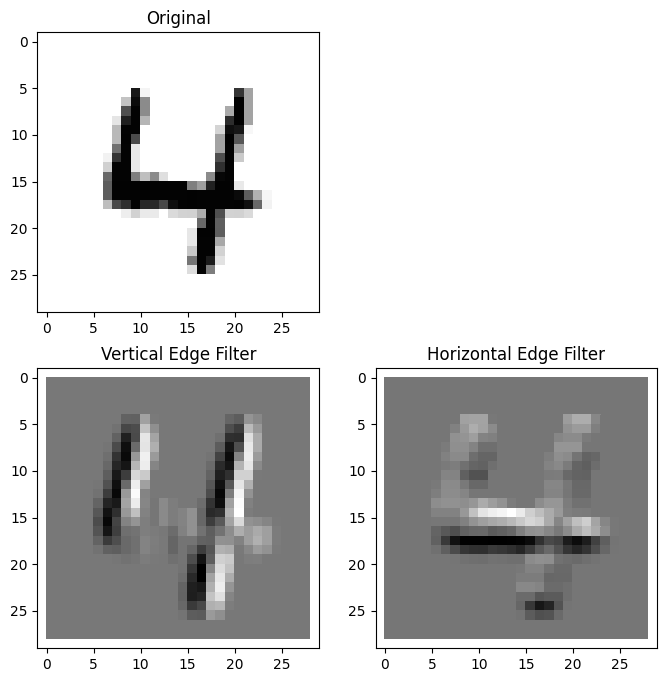

In [10]:
#4 查看結果
import matplotlib.pyplot as plt
%matplotlib inline

# 設定樣式
plt.figure(figsize=(8, 8))
plt.subplots_adjust(wspace=0.2)
plt.gray()

# 繪製原始圖像 
plt.subplot(2, 2, 1)
plt.pcolor(1 - img_x) 
plt.xlim(-1, 29)  
plt.ylim(29, -1)
plt.title("Original")

# 繪製縱向Filter結果
plt.subplot(2, 2, 3)
plt.pcolor(-vertical_edge)
plt.xlim(-1, 29)
plt.ylim(29, -1)
plt.title("Vertical Edge Filter")

# 繪製橫向Filter結果
plt.subplot(2, 2, 4)
plt.pcolor(-horizontal_edge)
plt.xlim(-1, 29)
plt.ylim(29, -1)
plt.title("Horizontal Edge Filter")
plt.show()

結果可以發現：
- 對於縱向Filter，縱向邊界非常明顯
- 對於橫向Filter，橫向邊界非常明顯

>由於這邊不是用0, 1，而是用-2, 1，所以差距比較大，結果比較明顯  
>而且所有元素的總和為0，所以如果選取的範圍中沒有邊界，運算結果剛好會是0

### 分割資料

重新提取資料並分割資料集

In [19]:
#5 分割資料集
# 讀取資料集
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_x = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# 提取x, y
train_x = train.drop(['label'], axis=1)
train_y = train['label']

# 分割資料
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

### 資料前處理

這裡要縮放資料、編碼並轉換成高28寬28通道1（灰階圖片）的矩陣

In [20]:
#6 資料處理
# 縮放資料
tr_x, va_x = np.array(tr_x / 255.0), np.array(va_x / 255.0)

# 轉換大小
tr_x = tr_x.reshape(-1,28,28,1)
va_x = va_x.reshape(-1,28,28,1)

# 用One-hot encoding編碼答案標籤
tr_y = to_categorical(tr_y, 10)
va_y = to_categorical(va_y, 10)

# 查看結果
print(tr_x.shape)
print(tr_y.shape)
print(va_x.shape)
print(va_y.shape)

(31500, 28, 28, 1)
(31500, 10)
(10500, 28, 28, 1)
(10500, 10)


### 建立卷積神經網路

這邊把CNN簡化為卷積層、展平層和輸出層

In [21]:
#7 建立模型
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

# 卷積層
model = Sequential()
model.add(Conv2D(filters=32,
                 kernel_size=(5, 5),
                 padding='same',
                 input_shape=(28, 28, 1),
                 activation='relu'))

# 展平層
model.add(Flatten())

# 輸出層
model.add(Dense(10, activation='softmax'))

# 編譯模型
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])            

# 輸出模型結構
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │         250,890 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,722 (983.29 KB)

 Trainable params: 251,722 (983.29 KB)

 Non-trainable params: 0 (0.00 B)

### 訓練模型

先手調超參數訓練模型試試看，看模型的表現如何

In [22]:
#8 訓練模型
history = model.fit(tr_x,
                    tr_y,
                    epochs=20,
                    batch_size=100,
                    verbose=1,
                    validation_data=(va_x, va_y))

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8443 - loss: 0.5037 - val_accuracy: 0.9674 - val_loss: 0.1170
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9715 - loss: 0.0975 - val_accuracy: 0.9750 - val_loss: 0.0849
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9832 - loss: 0.0593 - val_accuracy: 0.9785 - val_loss: 0.0721
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9871 - loss: 0.0468 - val_accuracy: 0.9802 - val_loss: 0.0667
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9888 - loss: 0.0384 - val_accuracy: 0.9803 - val_loss: 0.0696
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9918 - loss: 0.0311 - val_accuracy: 0.9792 - val_loss: 0.0690
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9933 - loss: 0.0245 - val_accuracy: 0.9819 - val_loss: 0.0685
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9930 - loss: 0.0242 - val_accuracy: 0.

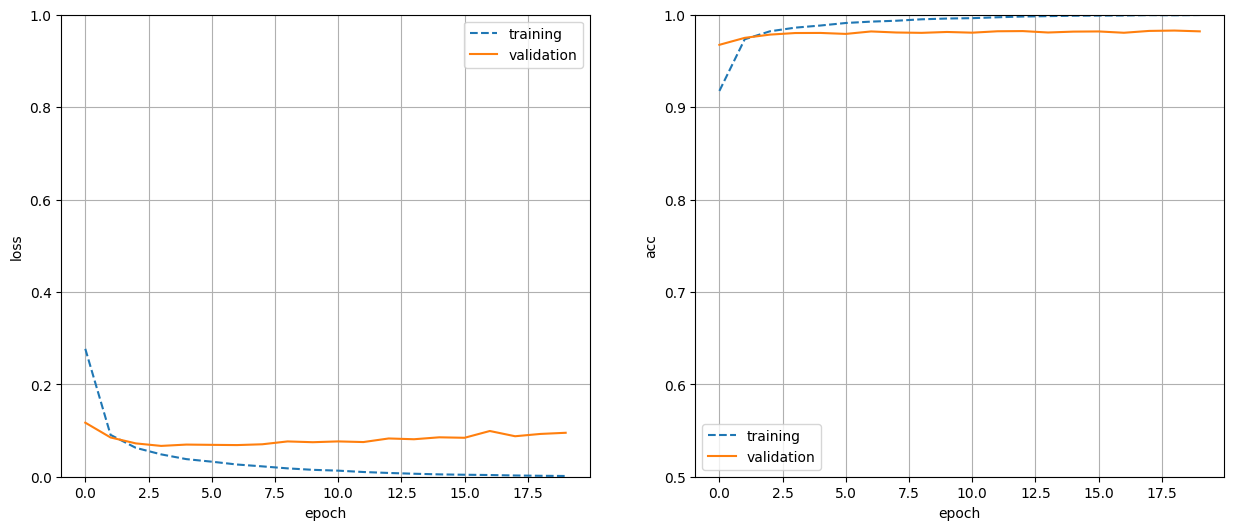

In [23]:
#9 查看訓練過程
%matplotlib inline
import matplotlib.pyplot as plt

# 設定圖表樣式
plt.figure(figsize=(15, 6))
plt.subplots_adjust(wspace=0.2)



# 訓練集Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],
         linestyle = '--',
         label='training')

# 驗證集Loss
plt.plot(history.history['val_loss'],
         label='validation')

plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# 訓練集準確率
plt.subplot(1, 2, 2)
plt.plot( history.history['accuracy'],
         linestyle = '--',
         label='training',)

# 驗證集準確率
plt.plot(history.history['val_accuracy'],
         label='validation')

plt.ylim(0.5, 1)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

結果發現：
- 驗證集的準確率在第5輪以後就沒什麼變化了，但訓練集的準確率持續提高且Loss持續下降（代表過擬合）
- 可以考慮執行Drop out

### 優化模型

這次放入更多卷積層，搭配Drop out, Pooling和貝氏優化來優化模型

In [24]:
#10 撰寫準備資料的函式
def prepare_data():
    # 讀取資料集
    train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
    test_x = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

    # 提取x, y
    train_x = train.drop(['label'], axis=1)  
    train_y = train['label']                  

    # 分割資料集
    kf = KFold(n_splits=4, shuffle=True, random_state=123)
    tr_idx, va_idx = list(kf.split(train_x))[0]
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    # 縮放x
    tr_x, va_x = np.array(tr_x / 255.0), np.array(va_x / 255.0)

    # 將圖像轉換成矩陣
    tr_x = tr_x.reshape(-1,28,28,1)
    va_x = va_x.reshape(-1,28,28,1)

    # 編碼y
    tr_y = to_categorical(tr_y, 10)
    va_y = to_categorical(va_y, 10)

    return tr_x, tr_y, va_x, va_y

In [25]:
#11 撰寫建立函式的模型
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from tensorflow.keras.layers import Dropout, MaxPooling2D, Input

# 建立模型
def create_model(params):
    # 提取資料
    tr_x, tr_y, va_x, va_y = prepare_data()
    model = Sequential()

    # 第1層 卷積層（探索Filter數量、尺寸）
    model.add(Input(shape=(28,28,1)))
    model.add(Conv2D(filters=params['conv1_filters'],
                     kernel_size=params['conv1_kernel'],
                     padding='same',
                     activation=params['conv1_activation'],))

    # 第2層 卷積層（探索Filter數量、尺寸）
    model.add(Conv2D(filters=params['conv2_filters'],
                     kernel_size=params['conv2_kernel'],
                     padding='same',
                     activation=params['conv2_activation']))

    # 第3層 池化層
    model.add(MaxPooling2D(pool_size=(2,2)))

    # 探索丟棄率
    model.add(Dropout(params['dropout1']))

    # 第4層 卷積層（探索Filter數量、尺寸）
    model.add(Conv2D(filters=params['conv3_filters'],
                     kernel_size=params['conv3_kernel'],
                     padding='same',
                     activation='relu'))

    # 第5層 卷積層（探索Filter數量、尺寸）
    model.add(Conv2D(filters=params['conv4_filters'],
                     kernel_size=params['conv4_kernel'],
                     padding='same',
                     activation=params['conv4_activation']))

    # 第6層 池化層
    model.add(MaxPooling2D(pool_size=(2,2)))

    # 探索丟棄率
    model.add(Dropout(params['dropout2']))

    # 第7層 展平層
    model.add(Flatten())

    # 探索要追加的層的數量
    if params['dense_layers'] == 'one':
        model.add(Dense(params['dense1_units'],
                        activation=params['dense1_activation']))
        
        model.add(Dropout(params['dropout3']))
    else:
        model.add(Dense(params['dense1_units'],
                        activation=params['dense1_activation']))
        
        model.add(Dropout(params['dropout3']))
        
        model.add(Dense(params['dense2_units'],
                        activation=params['dense2_activation']))
        
        model.add(Dropout(params['dropout4']))

    # 第8層 輸出層
    model.add(Dense(10, activation="softmax"))

    # 編譯模型
    model.compile(loss="categorical_crossentropy",
                  optimizer=params['optimizer'],
                  metrics=["accuracy"])

    # 訓練模型
    result = model.fit(tr_x, tr_y,
                       epochs=30,
                       batch_size=params['batch_size'],
                       validation_data=(va_x, va_y),
                       verbose=0)

    # 輸出訓練結果
    val_acc = np.amax(result.history['val_accuracy'])
    print("Best validation acc of epoch:", val_acc)
    return {'loss': -val_acc, 'status': STATUS_OK, 'model': model, 'history': result.history}

### Fine Tune

定義搜尋空間並進行超參數搜索

In [26]:
#12 定義搜尋空間
space = {'conv1_filters': hp.choice('conv1_filters', [32, 64]),
         'conv1_kernel': hp.choice('conv1_kernel', [(3,3), (5,5), (7,7)]),
         'conv1_activation': hp.choice('conv1_activation', ['tanh', 'relu']),
         'conv2_filters': hp.choice('conv2_filters', [32, 64]),
         'conv2_kernel': hp.choice('conv2_kernel', [(3,3), (5,5), (7,7)]),
         'conv2_activation': hp.choice('conv2_activation', ['tanh', 'relu']),
         'dropout1': hp.quniform('dropout1', 0.2, 0.6, 0.05),
         'conv3_filters': hp.choice('conv3_filters', [32, 64]),
         'conv3_kernel': hp.choice('conv3_kernel', [(3,3), (5,5), (7,7)]),
         'conv4_filters': hp.choice('conv4_filters', [32, 64]),
         'conv4_kernel': hp.choice('conv4_kernel', [(3,3), (5,5), (7,7)]),
         'conv4_activation': hp.choice('conv4_activation', ['tanh', 'relu']),
         'dropout2': hp.quniform('dropout2', 0.2, 0.6, 0.05),
         'dense_layers': hp.choice('dense_layers', ['one', 'two']),
         'dense1_units': hp.choice('dense1_units', [500, 600, 700]),
         'dense1_activation': hp.choice('dense1_activation', ['tanh', 'relu']),
         'dropout3': hp.quniform('dropout3', 0.1, 0.6, 0.05),
         'dense2_units': hp.choice('dense2_units', [100, 150, 200]),
         'dense2_activation': hp.choice('dense2_activation', ['tanh', 'relu']),
         'dropout4': hp.quniform('dropout4', 0.2, 0.6, 0.05),
         'optimizer': hp.choice('optimizer', ['adam', 'rmsprop']),
         'batch_size': hp.choice('batch_size', [100, 200, 300])}

In [27]:
#13 進行搜尋
trials = Trials()
best = fmin(fn=create_model,
            space=space,
            algo=tpe.suggest,
            max_evals=75,
            trials=trials)

Best validation acc of epoch:                         
0.9933333396911621                                    
Best validation acc of epoch:                                                       
0.9930475950241089                                                                  
Best validation acc of epoch:                                                       
0.9939047694206238                                                                  
Best validation acc of epoch:                                                       
0.9945714473724365                                                                  
Best validation acc of epoch:                                                       
0.9950476288795471                                                                  
Best validation acc of epoch:                                                       
0.9905714392662048                                                                  
Best validation acc of epoch:           

### 評估訓練結果

查看最佳模型的結構、最佳超參數，並用驗證資料評估模型

In [28]:
#14 評估訓練結果
# 取得最佳模型
best_result = sorted(trials.results, key=lambda x: x['loss'])[0]
best_model = best_result['model']

# 輸出最佳模型與最佳參數
print(best_model.summary())
print("Best hyperparameters:", best)

# 使用驗證資料評估模型
_, _, va_x, va_y = prepare_data()
val_loss, val_acc = best_model.evaluate(va_x, va_y)
print("val_loss:", val_loss)
print("val_acc:", val_acc)

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_283 (Conv2D)                  │ (None, 28, 28, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_284 (Conv2D)                  │ (None, 28, 28, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_140 (MaxPooling2D)     │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_261 (Dropout)                │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_285 (Conv2D)                  │ (None, 14, 14, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_286 (Conv2D)                  │ (None, 14, 14, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_141 (MaxPooling2D)     │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_262 (Dropout)                │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_73 (Flatten)                 │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_194 (Dense)                    │ (None, 500)                 │         784,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_263 (Dropout)                │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_195 (Dense)                    │ (None, 150)                 │          75,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_264 (Dropout)                │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_196 (Dense)                    │ (None, 10)                  │           1,510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,028,946 (7.74 MB)

 Trainable params: 1,014,472 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,014,474 (3.87 MB)

None
Best hyperparameters: {'batch_size': 1, 'conv1_activation': 1, 'conv1_filters': 1, 'conv1_kernel': 1, 'conv2_activation': 1, 'conv2_filters': 0, 'conv2_kernel': 1, 'conv3_filters': 0, 'conv3_kernel': 2, 'conv4_activation': 0, 'conv4_filters': 0, 'conv4_kernel': 2, 'dense1_activation': 0, 'dense1_units': 0, 'dense2_activation': 0, 'dense2_units': 1, 'dense_layers': 1, 'dropout1': 0.45, 'dropout2': 0.5, 'dropout3': 0.5, 'dropout4': 0.25, 'optimizer': 1}
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9940 - loss: 0.0294
val_loss: 0.021643657237291336
val_acc: 0.9954285621643066


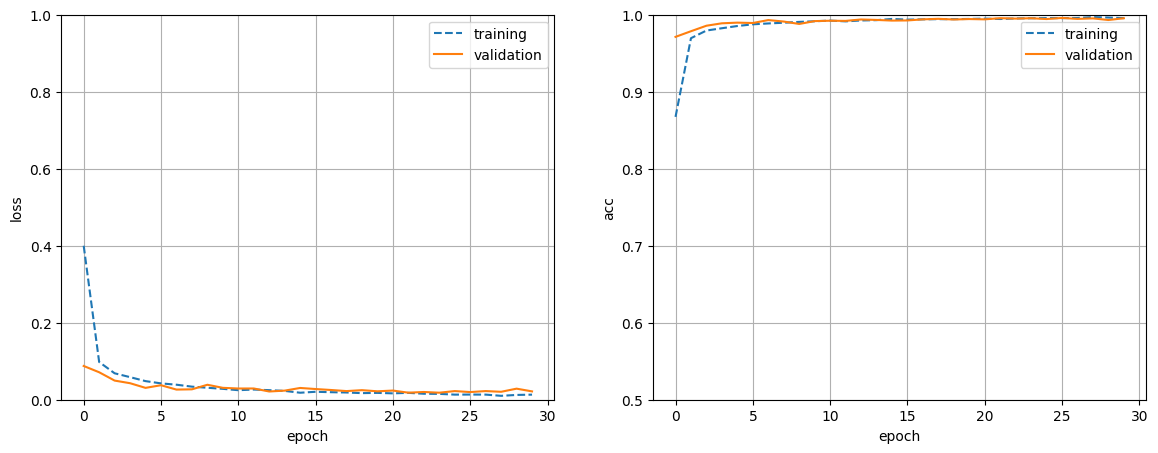

In [33]:
#15 查看訓練過程
# 取得最佳訓練紀錄
best_history = best_result['history']

plt.figure(figsize=(14, 5))

# 訓練集Loss
plt.subplot(1, 2, 1)
plt.plot(best_history['loss'],
         linestyle = '--',
         label='training')

# 驗證集Loss
plt.plot(best_history['val_loss'],
         label='validation')

plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# 訓練集準確率
plt.subplot(1, 2, 2)
plt.plot(best_history['accuracy'],
         linestyle = '--',
         label='training')

# 驗證集準確率
plt.plot(best_history['val_accuracy'],
         label='validation')

plt.ylim(0.5, 1)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

可以發現：
- 這次驗證集的準確度也來到99%了
- 訓練的後半段訓練集和驗證集的準確度、Loss幾乎重疊，代表多加卷積層和池化對驗證集有效